In [12]:
import ccxt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy.interpolate import interp1d
from talib import EMA
import warnings
warnings.filterwarnings('ignore')

**Load historical XBTUSD market data**

The Open, High, Low, Close (OHLC or candle) data here ranges from 01-Jan-2019 to 01-Nov-2020

In [13]:
df = pd.read_parquet(r'C:\Users\Nomade05\Elie code\Datas\XBTUSD.parquet')

print(f'{len(df)} market data points')
df.head()

966240 market data points


time    open    high     low   close       vol
0 2019-01-01 00:01:00  3693.0  3694.5  3693.0  3694.5  891545.0
1 2019-01-01 00:02:00  3694.5  3694.5  3690.5  3690.5  658961.0
2 2019-01-01 00:03:00  3690.5  3691.0  3690.5  3690.5  196138.0
3 2019-01-01 00:04:00  3690.5  3691.0  3690.0  3690.0  263296.0
4 2019-01-01 00:05:00  3690.0  3690.5  3688.5  3688.5  716426.0

## Trading strategy idea : exponential moving average (EMA)  
- Only place a sell order if 5 period EMA is below 20 period EMA
- Only place a buy order if 5 period EMA is above 20 period EMA

In [14]:
df['EMA_5'] = EMA(df['close'], 5)
df['EMA_20'] = EMA(df['close'], 20)


df['signal'] = df.apply(lambda x: x['EMA_5'] - x['EMA_20'], axis = 1)


df = df.tail(400)
df.reset_index(inplace=True, drop=True)
df

time     open     high      low    close        vol  \
0   2020-11-01 17:21:00  13799.5  13802.0  13799.5  13802.0   172459.0   
1   2020-11-01 17:22:00  13802.0  13802.0  13799.0  13799.0   464971.0   
2   2020-11-01 17:23:00  13799.0  13801.5  13799.0  13801.0    60289.0   
3   2020-11-01 17:24:00  13801.0  13801.5  13800.5  13800.5   278579.0   
4   2020-11-01 17:25:00  13800.5  13801.0  13800.0  13800.5   426900.0   
..                  ...      ...      ...      ...      ...        ...   
395 2020-11-01 23:56:00  13737.5  13746.0  13737.5  13746.0  2356171.0   
396 2020-11-01 23:57:00  13746.0  13760.0  13743.5  13749.5  2022692.0   
397 2020-11-01 23:58:00  13749.5  13752.5  13750.0  13750.5   656155.0   
398 2020-11-01 23:59:00  13750.5  13760.0  13750.0  13760.0   535721.0   
399 2020-11-02 00:00:00  13760.0  13760.0  13753.5  13756.5   583285.0   

            EMA_5        EMA_20     signal  
0    13796.087449  13790.970633   5.116816  
1    13797.058299  13791.735334   5.322965  
2    13798.372199  13792.617684   5.754516  
3    13799.081466  13793.368380   5.713086  
4    13799.554311  13794.047582   5.506729  
..            ...           ...        ...  
395  13734.370358  13726.081795   8.288563  
396  13739.413572  13728.312100  11.101472  
397  13743.109048  13730.425233  12.683815  
398  13748.739365  13733.241878  15.497488  
399  13751.326243  13735.456937  15.869307  

[400 rows x 9 columns]

In [15]:
def strategy(close, signal):
    buy_price = []
    sell_price = []
    EMA_signal = []
    
    
    for i in range(0,len(df)-1):
        
        if df['signal'][i] > 0 and df['signal'][i+1] < 0:
            sell_price.append(df['close'][i])
            buy_price.append(np.nan)            
            EMA_signal.append(df['signal'][i])            
        
                
        if df['signal'][i] < 0 and df['signal'][i+1] > 0:           
            sell_price.append(np.nan)
            buy_price.append(df['close'][i])            
            EMA_signal.append(df['signal'][i])  
            
        if df['signal'][i] < 0 and df['signal'][i+1] < 0:           
            sell_price.append(np.nan)
            buy_price.append(np.nan)            
            EMA_signal.append(np.nan)  
        
        if df['signal'][i] > 0 and df['signal'][i+1] > 0:           
            sell_price.append(np.nan)
            buy_price.append(np.nan)            
            EMA_signal.append(np.nan)  
            
            
    sell_price.append(np.nan)
    buy_price.append(np.nan)            
    EMA_signal.append(np.nan)
           
     
            
    return buy_price, sell_price, EMA_signal
    
buy_price, sell_price, EMA_signal = strategy(df['close'], df['signal'])

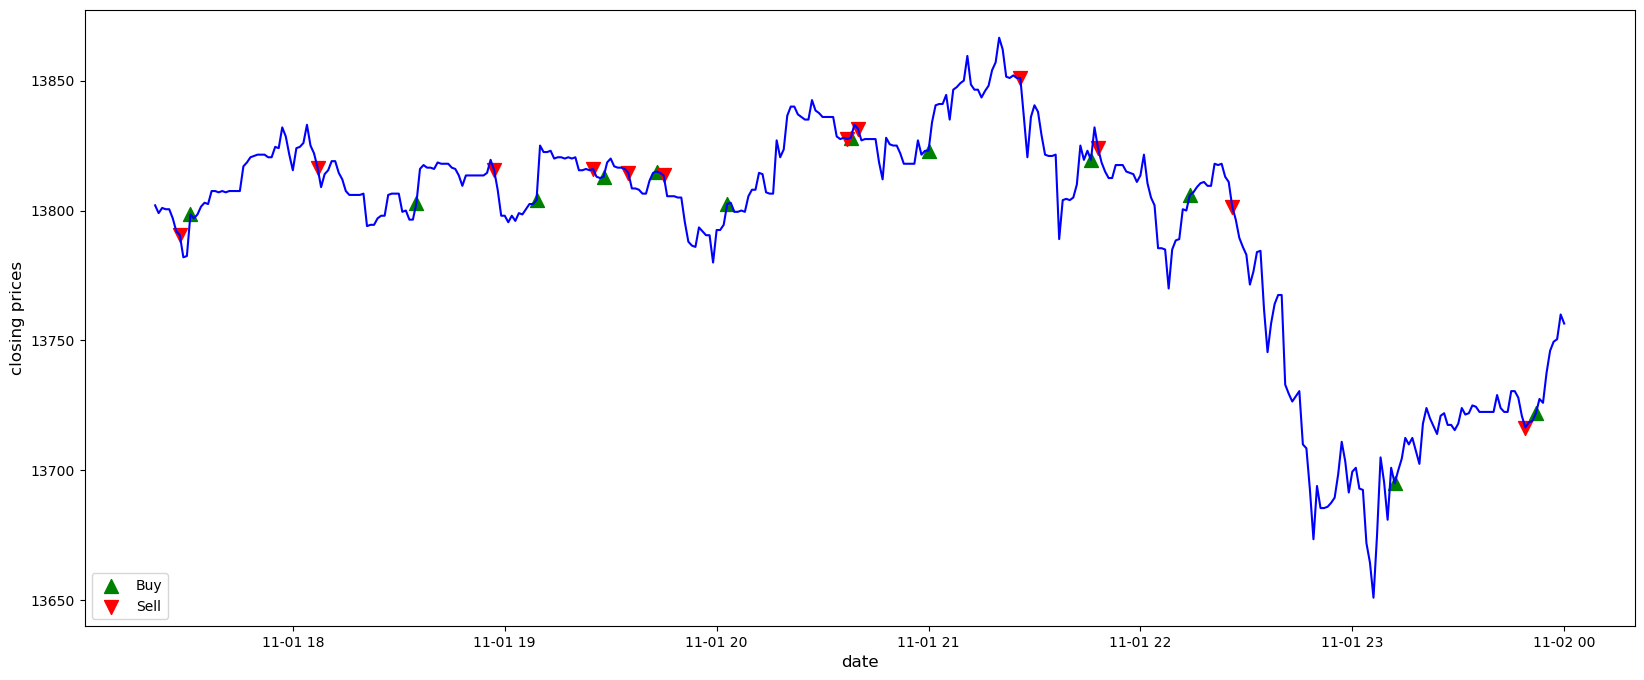

In [16]:
fig, ax = plt.subplots(figsize=(20, 8))


ax.plot(df['time'], df['close'], 'b-')

ax.set_xlabel('date')
ax.set_ylabel('close price')
plt.scatter(df.time, buy_price, marker = '^', color = 'green', label = 'Buy', s = 100)
plt.scatter(df.time, sell_price, marker = 'v', color = 'red', label = 'Sell', s = 100)

plt.legend(loc = 'lower left')
plt.ylabel('closing prices', fontsize=12)
plt.xlabel('date', fontsize=12)
plt.show()